In [70]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import matplotlib.animation as animation
%matplotlib inline

In [71]:
L = 50
N = 20
x = np.arange(0, L, 1)
y = np.arange(0, L, 1)
delta_theta = np.zeros(N)
v = np.ones(N)*0.3

##x represents coordinates, v has the components of the velocity (probably superfluous, psi is the orientation, omega is the 
##angular velocity and r is the radius.
particles_x = np.zeros([N, 2])
particles_v = np.zeros([N, 2])
particles_omega = np.zeros(N)
particles_psi = np.random.uniform(-np.pi/4, np.pi/4, N)
particles_r = np.zeros(N)

In [72]:
# for i in range (int(N/10)):
#     particles_x[10*i:(10*(i+1)), 0] = np.arange(int(L/2 -5), int(L/2 + 5), 1) + np.random.uniform(-0.1, 0.1, 10)
#     particles_x[int(N*i/10): int(N*(i+1)/10), 1] = int(L/2 -i) + np.random.uniform(-0.1, 0.1, int(N/10))
particles_x[:, 0] = np.array([5*np.cos(2*np.pi/N * i)+10 for i in range(N)]) 
particles_x[:, 1] = np.array([5*np.sin(2*np.pi/N * i)+10 for i in range(N)]) 
#particles_r[:] = np.random.normal(1, 0.1, N)
particles_r[:] = 0

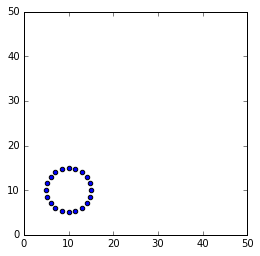

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([0, L])
ax.set_ylim([0, L])
ax.set_aspect(1)
plt.scatter(particles_x[:, 0], particles_x[:, 1])
plt.show()

In [74]:
def update(L, particles_x, particles_r, particles_psi):
    dist_components = particles_x[None, :, :] - particles_x[:, None, :]
    dist_components = dist_components - np.rint(dist_components/L)*L
    distances = np.linalg.norm(dist_components, axis = 2)
    
    neighs = np.zeros([N, N])
    neighs[(distances < 2.7) & (distances >0)] = 1
    
    radii_sum = np.zeros([N, N])
    for i in range (N):
        radii_sum[i, :] = particles_r + particles_r[i]
    
    overlap = np.zeros([N, N])
    overlap[distances - radii_sum < 0] = np.abs((distances - radii_sum)[distances - radii_sum < 0])
    np.fill_diagonal(overlap, 0)
    
    ##we need to avoid dividing by zero
    np.fill_diagonal(dist_components[:, :, 0], 100)
    
    angles = np.arctan2(dist_components[:, :, 1], dist_components[:, :, 0])
    
    np.fill_diagonal(dist_components[:, :, 0], 0)
    
    d = repulsion_force(N, angles, overlap)
    
    delta_theta, theta_in, theta_out = angles_calc(neighs, angles, particles_psi)
    
    print("------theta in")
    print(theta_in)
    
    print("------theta out")
    print(theta_out)
    
    F_self = 0
    F_boundary = (theta_out - np.pi)*0.3*(theta_out > np.pi)
    
    particles_x[:, 0] = np.mod(particles_x[:, 0] + F_self + F_boundary*np.cos(theta_in)+ 1*d[:, 0], L)
    particles_x[:, 1] = np.mod(particles_x[:, 1] + F_boundary*np.sin(theta_in) + 1*d[:, 1], L)
    return particles_x

def repulsion_force(N, angles, overlap):
    d = np.zeros([N, N, 2])
    d[:, :, 0] = np.cos(angles)*overlap 
    d[:, :, 1] = np.sin(angles)*overlap 
    d = np.sum(d, axis = 1)
    return d

def angles_calc(neighs, angles, particles_psi):
    neigh_angles = neighs*angles
    
    delta_theta = np.zeros(N)
    theta_in = np.zeros(N)
    theta_out = np.zeros(N)
    
    for i in range (N):
        sorted_angles = np.sort(neigh_angles[i, :][np.nonzero(neigh_angles[i, :])])
        angles_difference = np.roll(sorted_angles, 1) - sorted_angles
        max_index = np.argmax(angles_difference)
        if angles_difference[max_index] > np.pi:
            theta_out[i] = angles_difference[max_index]
            theta_in[i] = (np.roll(sorted_angles, 1)[max_index] + sorted_angles[max_index])/2
            delta_theta[i] = theta_in[i] - particles_psi[i]
        
        print("----")
        print(angles_difference)
        print(sorted_angles)
    
            
    return delta_theta, theta_in, theta_out

----
[ 3.45575192 -3.45575192]
[-1.72787596  1.72787596]
----
[ 3.45575192 -3.45575192]
[-1.41371669  2.04203522]
----
[ 3.45575192 -3.45575192]
[-1.09955743  2.35619449]
----
[ 3.45575192 -3.45575192]
[-0.78539816  2.67035376]
----
[ 3.45575192 -3.45575192]
[-0.4712389   2.98451302]
----
[ 2.82743339 -2.82743339]
[-2.98451302 -0.15707963]
----
[ 2.82743339 -2.82743339]
[-2.67035376  0.15707963]
----
[ 2.82743339 -2.82743339]
[-2.35619449  0.4712389 ]
----
[ 2.82743339 -2.82743339]
[-2.04203522  0.78539816]
----
[ 2.82743339 -2.82743339]
[-1.72787596  1.09955743]
----
[ 2.82743339 -2.82743339]
[-1.41371669  1.41371669]
----
[ 2.82743339 -2.82743339]
[-1.09955743  1.72787596]
----
[ 2.82743339 -2.82743339]
[-0.78539816  2.04203522]
----
[ 2.82743339 -2.82743339]
[-0.4712389   2.35619449]
----
[ 2.82743339 -2.82743339]
[-0.15707963  2.67035376]
----
[ 2.82743339 -2.82743339]
[ 0.15707963  2.98451302]
----
[ 3.45575192 -3.45575192]
[-2.98451302  0.4712389 ]
----
[ 3.45575192 -3.45575192]


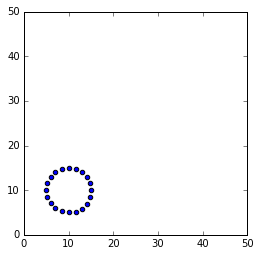

In [75]:
for i in range (1):
    particles_x = update(L, particles_x, particles_r, particles_psi)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim([0, L])
    ax.set_ylim([0, L])
    ax.set_aspect(1)
    plt.scatter(particles_x[:, 0], particles_x[:, 1])
    plt.show()